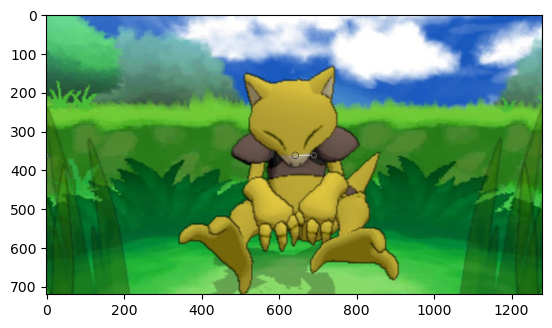

In [1]:
# Read .jpg
import imageio.v3 as iio
import matplotlib.pyplot as plt

im_path = 'data/pokemon/Abra/00000023.jpg'
img = iio.imread(im_path)

plt.imshow(img)
plt.show()

In [2]:
import sys
sys.path.append('RMBG-1.4')

from skimage import io
import torch
from typing import Optional
from PIL import Image
from briarmbg import BriaRMBG
from utilities import preprocess_image, postprocess_image


net = BriaRMBG()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BriaRMBG.from_pretrained("briaai/RMBG-1.4")
net.to(device)
net.eval()    

def remove_background(im_path) -> Optional[Image]:
    try:
        # prepare input
        model_input_size = [1024,1024]
        orig_im = io.imread(im_path)
        orig_im = orig_im[:,:,:3] # remove alpha channel
        orig_im_size = orig_im.shape[0:2]
        image = preprocess_image(orig_im, model_input_size).to(device)

        # inference 
        result=net(image)

        # post process
        result_image = postprocess_image(result[0][0], orig_im_size)

        # save result
        pil_im = Image.fromarray(result_image)
        no_bg_image = Image.new("RGBA", pil_im.size, (0,0,0,0))
        orig_image = Image.open(im_path)
        no_bg_image.paste(orig_image, mask=pil_im)
        return no_bg_image

    except Exception as e:
        print(f"{e, im_path, orig_im.shape, orig_im_size}")
        return None


c:\Users\hiroga\miniconda3\envs\background-removal\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


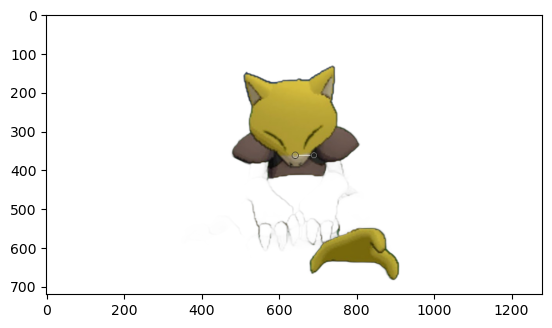

In [3]:
# Remove image from .jpg
import matplotlib.pyplot as plt
import os

im_path = 'data/pokemon/Abra/00000023.jpg'
no_bg_image = remove_background(im_path)
out_path = im_path.replace("data/pokemon", "data/pokemon_no_bg").replace(".jpg", ".png")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
no_bg_image.save(out_path)

plt.imshow(no_bg_image)
plt.show()

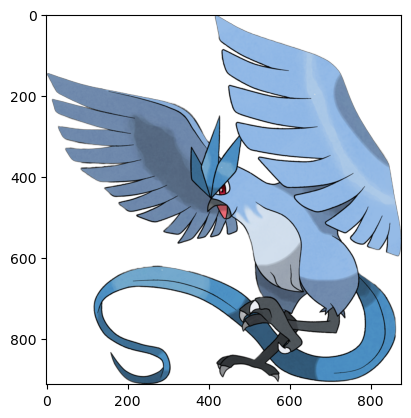

In [4]:
# Remove image from .png with alpha channel
import matplotlib.pyplot as plt
import os

im_path = 'data/pokemon/Articuno/00000009.png'
no_bg_image = remove_background(im_path)
out_path = im_path.replace("data/pokemon", "data/pokemon_no_bg").replace(".jpg", ".png")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
no_bg_image.save(out_path)

plt.imshow(no_bg_image)
plt.show()

In [11]:
# Benchmarking
import os
import time

directory = 'data/pokemon/Pikachu'

image_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if os.path.splitext(filename)[1].lower() in [".jpg", ".png"]]

start_time = time.time()

for image_path in image_paths:
    no_bg_image = remove_background(image_path)
    if no_bg_image is None:
        print(f"Failed to remove background from {image_path}")
        continue
    out_path = image_path.replace("data/pokemon", "data/pokemon_no_bg")
    out_path = f"{os.path.splitext(out_path)[0]}.png"
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    no_bg_image.save(out_path)

end_time = time.time()
execution_time = end_time - start_time

print(f"Background removal benchmark completed. Total execution time: {execution_time} seconds.")


c:\Users\hiroga\miniconda3\envs\background-removal\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(RuntimeError('permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3'), 'data/pokemon/pikachu\\00000147.jpg', (1, 1024, 3, 3), (1, 1024))
Failed to remove background from data/pokemon/pikachu\00000147.jpg
Background removal benchmark completed. Total execution time: 46.87978553771973 seconds.


In [ ]:
# Debug
from skimage import io

for im_path in ["data/pokemon/Pikachu/00000000.jpg","data/pokemon/Pikachu/00000000.png","data/pokemon/Pikachu/00000147.jpg"]:
    shape = io.imread(im_path).shape
    print(f"{im_path, shape}")

# ('data/pokemon/Pikachu/00000147.jpg', (1, 1024, 957, 3))
# 4次元の形状である。WindowsのExplorerではサムネイルが表示できるが、Photosでは表示できないので、これは壊れている例外として扱う。

('data/pokemon/Pikachu/00000000.jpg', (796, 796, 3))
('data/pokemon/Pikachu/00000000.png', (1280, 1280, 4))
('data/pokemon/Pikachu/00000147.jpg', (1, 1024, 957, 3))


In [12]:
import numpy as np

def remove_background_batch(image_paths, batch_size=10) -> Image:
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        for im_path in batch_paths:
            orig_im = io.imread(im_path)
            if orig_im.ndim == 4 and orig_im.shape[0] == 1:  # if the image is 4D with first dimension being 1
                orig_im = orig_im[0]  # remove the first dimension
            orig_im = orig_im[:,:,:3]  # remove alpha channel
            batch_images.append(orig_im)
        batch_images = np.stack(batch_images, axis=0) # ValueError: all input arrays must have the same shape
        batch_images = preprocess_image(batch_images, model_input_size).to(device)
        results = net(batch_images)
        for j, result in enumerate(results):
            result_image = postprocess_image(result[0][0], orig_im_size)
            pil_im = Image.fromarray(result_image)
            no_bg_image = Image.new("RGBA", pil_im.size, (0,0,0,0))
            orig_image = Image.open(batch_paths[j])
            no_bg_image.paste(orig_image, mask=pil_im)
            out_path = batch_paths[j].replace("data/pokemon", "data/pokemon_no_bg")
            out_path = f"{os.path.splitext(out_path)[0]}.png"
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            no_bg_image.save(out_path)

In [13]:
# Benchmarking
import os
import time

directory = 'data/pokemon/pikachu'

image_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if os.path.splitext(filename)[1].lower() in [".jpg", ".png"]]

start_time = time.time()

remove_background_batch(image_paths)

end_time = time.time()
execution_time = end_time - start_time

print(f"Background removal benchmark completed. Total execution time: {execution_time} seconds.")


ValueError: all input arrays must have the same shape